In [5]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.applications.xception import Xception

import keras
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

import time
from datetime import timedelta

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.data import Dataset

from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adagrad


In [48]:
DATA_PATH = "../../Data/"
IMG_SIZE = (229, 229)
IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated_xception_balanced/"
IMAGES_PATH_VALIDATION = DATA_PATH+"HAM10000_images_separated_validation_xception/"

In [29]:
batch_size = 32
generator = ImageDataGenerator(validation_split=0.2)
train_data = generator.flow_from_directory( 
        subset="training",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size
)
test_data = generator.flow_from_directory( 
        subset="validation",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size
)

Found 781 images belonging to 7 classes.
Found 192 images belonging to 7 classes.


In [32]:
def print_training_history(history: keras.callbacks.History) -> None:
    
    epochs = len(history.history['loss'])
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
    plt.xlabel("Epochs")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
    plt.xlabel("Epochs")
    plt.title("Training and Validation Loss")
    plt.show()

In [4]:
def evaluate_model(model: Sequential, train_ds: Dataset, test_ds: Dataset) -> None:
    acc_value = model.evaluate(train_ds, verbose=0)[1]
    val_acc_value = model.evaluate(test_ds, verbose=0)[1]
    print("Model Accuracy      : {0:.4f}".format(acc_value))
    print("Validation Accuracy : {0:.4f}".format(val_acc_value))

## Xception

In [35]:
# Loading VGG16 model without top layers to substitute with custom Dense layers
base_model = Xception(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False # Not trainable weights
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 229, 229, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 114, 114, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 114, 114, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [24]:
# Enable training for convolutional layers in last (14th) block
if False:
    for layer in base_model.layers:
        # These 2 layers will enable 4,741,632 Trainable params: 
        if layer.name not in ["block14_sepconv1", "block14_sepconv2"]:
            layer.trainable = False

    base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 229, 229, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 114, 114, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 114, 114, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

### TODO : https://stackoverflow.com/questions/54011173/is-there-any-documentation-about-default-weight-initializer-in-keras
Layer Weight Init

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_33 (Rescaling)    (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_33 (Flatten)        (None, 100352)            0         
                                                                 
 dense_120 (Dense)           (None, 1024)              102761472 
                                                                 
 dropout_81 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_102 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                     

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


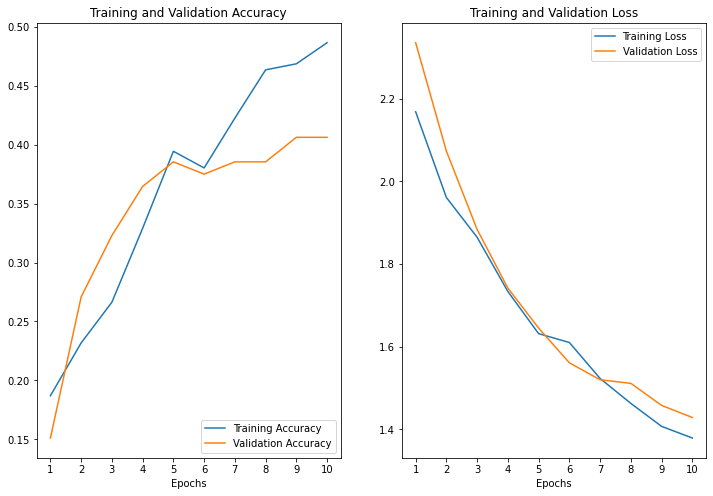

In [62]:
# Measure time
start_time = time.time()

epochs = 10
dropout_rate = 0.4
weight_init = tf.keras.initializers.Orthogonal()

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=IMG_SIZE+(3,)),
    base_model,
    layers.Flatten(),
    
    layers.Dense(1024, kernel_initializer=weight_init ),
    layers.Dropout(dropout_rate),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Dense(512, kernel_initializer=weight_init),
    layers.Dropout(dropout_rate),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Dense(256, kernel_initializer=weight_init),
    layers.Dropout(dropout_rate),
    layers.BatchNormalization(),
    layers.ReLU(),
    
    layers.Dense(128, kernel_initializer=weight_init),
    layers.Dropout(dropout_rate),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dense(7, activation="softmax")
])

model.summary()

optimizer = K.optimizers.Adam(learning_rate=0.00025, epsilon=1e-06) 
# RMSprop(learning_rate=0.00002) # Adagrad() # Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_loss', mode='min', patience=3,  
                   restore_best_weights=True, min_delta=0.01)

history = model.fit(train_data, validation_data=test_data, 
                    batch_size=batch_size, epochs=epochs) #, callbacks=[es])
epochs = len(history.history['loss'])

print("Epoch Length : {0}".format(epochs))
print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

# Custom Mask Warning indicates on loading model will require mask layers to be passed as custom_objects
model.save("output\keras_models\skin_classifier_Xception_{0}.keras".format(epochs))
#evaluate_model(model, train_data, test_data)
print_training_history(history)
'''''';
# Xception+Dense256 (Dense[1024,512,258,128]+DO.4+BN+ReLU)x4 Orthogonal

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_32 (Rescaling)    (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_32 (Flatten)        (None, 100352)            0         
                                                                 
 dense_115 (Dense)           (None, 1024)              102761472 
                                                                 
 dropout_77 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_98 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                     

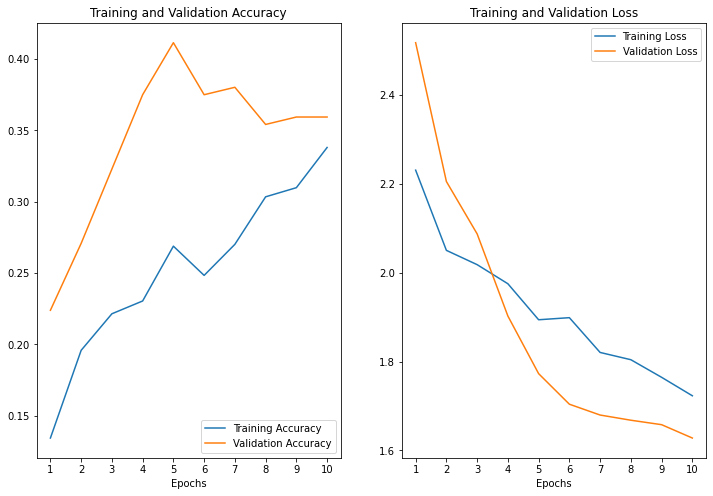

In [61]:
# Xception+Dense256 (Dense[1024,512,258,128]+DO.5+BN+ReLU)x4 HeNormal

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_30 (Rescaling)    (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_30 (Flatten)        (None, 100352)            0         
                                                                 
 dense_105 (Dense)           (None, 1024)              102761472 
                                                                 
 dropout_69 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_90 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                     

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


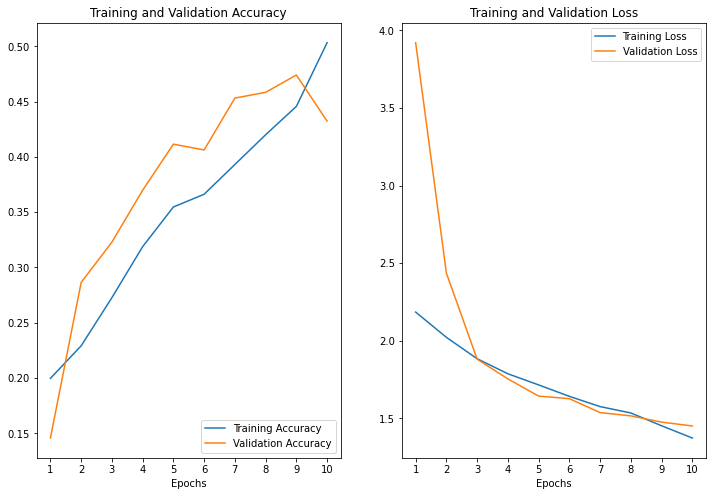

In [59]:
# Xception+Dense256 (Dense[1024,512,258,128]+DO.4+BN+ReLU)x4 HeNormal

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_29 (Rescaling)    (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_29 (Flatten)        (None, 100352)            0         
                                                                 
 dense_100 (Dense)           (None, 1024)              102761472 
                                                                 
 dropout_65 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_86 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                     

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


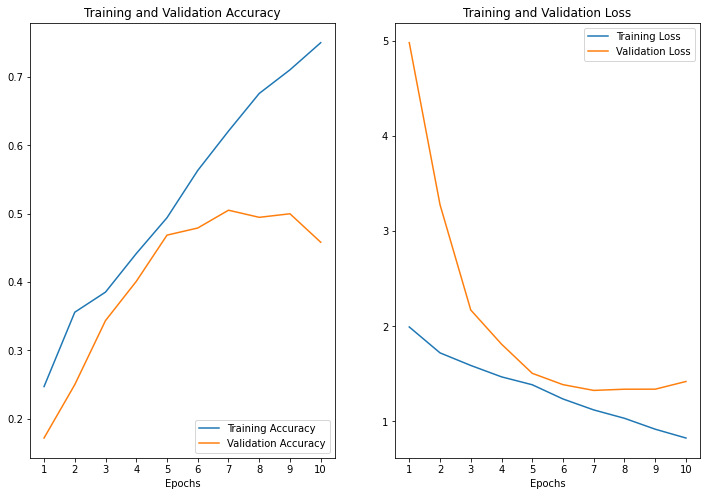

In [58]:
# Xception+Dense256 (Dense[1024,512,258,128]+DO.3+BN+ReLU)x4 HeUniform

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_28 (Rescaling)    (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_28 (Flatten)        (None, 100352)            0         
                                                                 
 dense_95 (Dense)            (None, 1024)              102761472 
                                                                 
 dropout_61 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_82 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                     

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


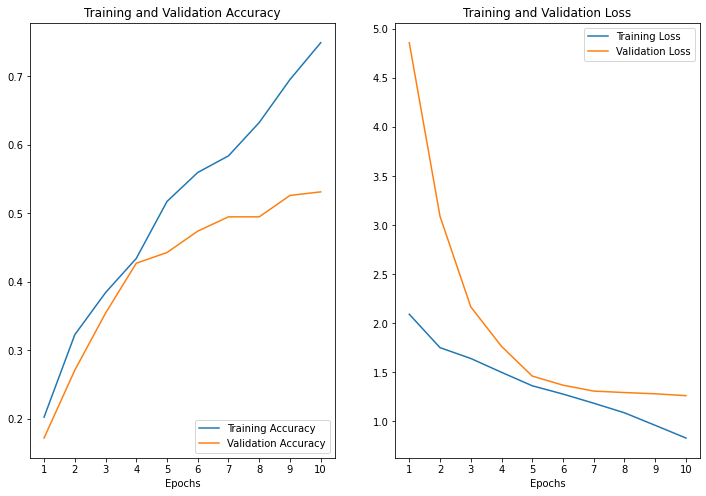

In [57]:
# Xception+Dense256 (Dense[1024,512,258,128]+DO.3+BN+ReLU)x4 HeNormal

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_27 (Rescaling)    (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_27 (Flatten)        (None, 100352)            0         
                                                                 
 dense_90 (Dense)            (None, 1024)              102761472 
                                                                 
 dropout_57 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_78 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                     

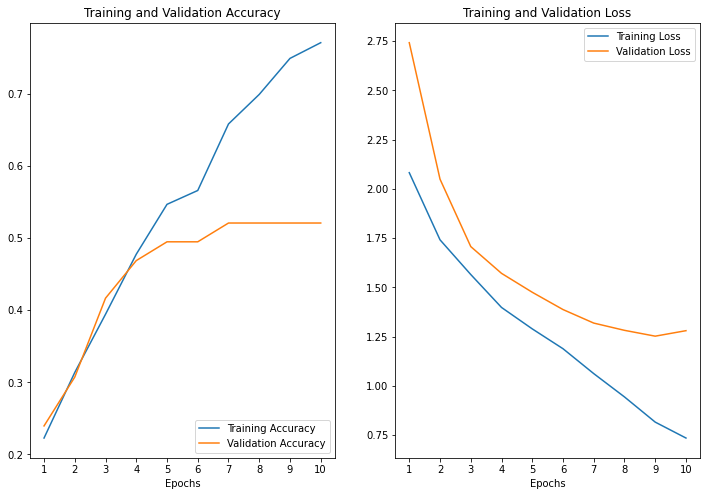

In [56]:
# Xception+Dense256 (Dense[1024,512,258,128]+DO.3+BN+ReLU)x4 1.03e+08 Trainable Parameter

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_26 (Rescaling)    (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_26 (Flatten)        (None, 100352)            0         
                                                                 
 dense_85 (Dense)            (None, 1024)              102761472 
                                                                 
 dropout_53 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_74 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                     

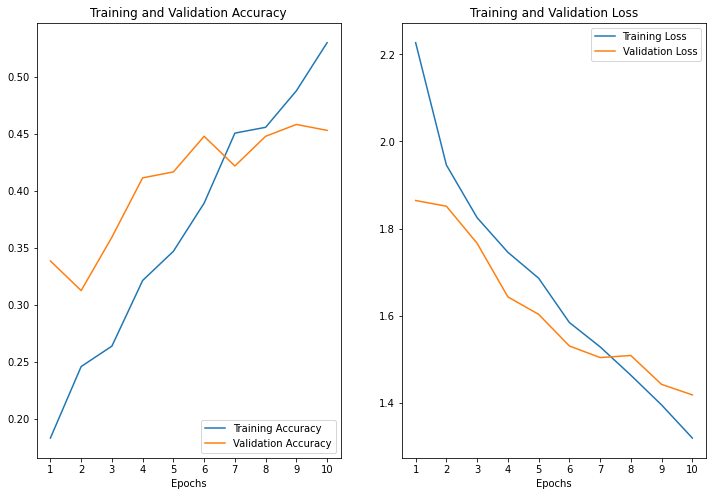

In [55]:
# Xception+Dense256 (Dense[1024,512,258,128]+DO.4+BN+ReLU)x4 1.03e+08 Trainable Parameter

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_25 (Rescaling)    (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_25 (Flatten)        (None, 100352)            0         
                                                                 
 dense_80 (Dense)            (None, 1024)              102761472 
                                                                 
 dropout_49 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_70 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                     

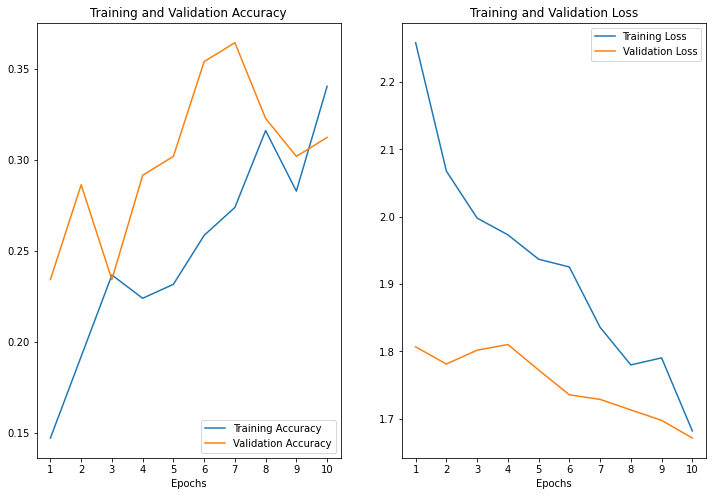

In [54]:

# Xception+Dense256 (Dense[1024,512,258,128]+DO.5+BN+ReLU)x4 1.03e+08 Trainable Parameter

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 229, 229, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_19 (Flatten)        (None, 100352)            0         
                                                                 
 dense_50 (Dense)            (None, 256)               25690368  
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_46 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                     

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


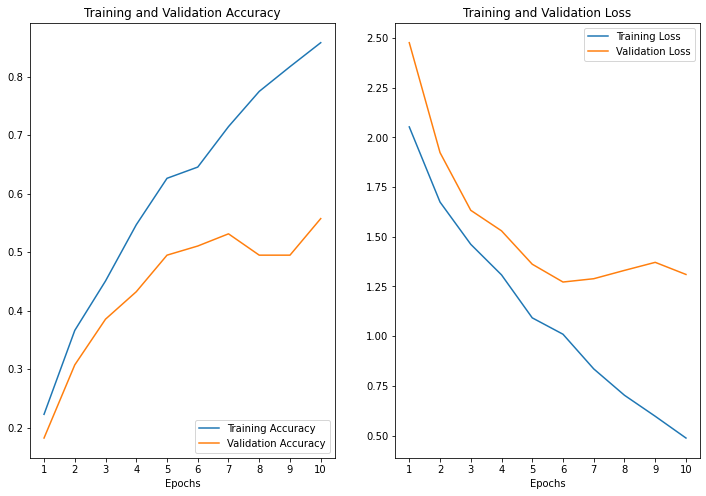

In [47]:
# Xception+Dense256 (D256+DO+BN+ReLU)x4 25e+6 Trainable param

Epoch 1/10
25/25 [==============================] - 40s 2s/step - loss: 3.8740 - accuracy: 0.3214 - val_loss: 1.5150 - val_accuracy: 0.4635
Epoch 2/10
25/25 [==============================] - 38s 2s/step - loss: 1.0250 - accuracy: 0.6466 - val_loss: 1.2488 - val_accuracy: 0.5000
Epoch 3/10
25/25 [==============================] - 38s 2s/step - loss: 0.6286 - accuracy: 0.8195 - val_loss: 1.2400 - val_accuracy: 0.5156
Epoch 4/10
25/25 [==============================] - 38s 2s/step - loss: 0.4063 - accuracy: 0.8873 - val_loss: 1.2512 - val_accuracy: 0.5156
Epoch 5/10
25/25 [==============================] - 38s 2s/step - loss: 0.2356 - accuracy: 0.9667 - val_loss: 1.2263 - val_accuracy: 0.5469
Epoch 6/10
25/25 [==============================] - 38s 2s/step - loss: 0.1461 - accuracy: 0.9859 - val_loss: 1.3241 - val_accuracy: 0.5521
Epoch 7/10
25/25 [==============================] - 38s 2s/step - loss: 0.0950 - accuracy: 0.9923 - val_loss: 1.2962 - val_accuracy: 0.5469
Epoch 8/10
25/25 [==

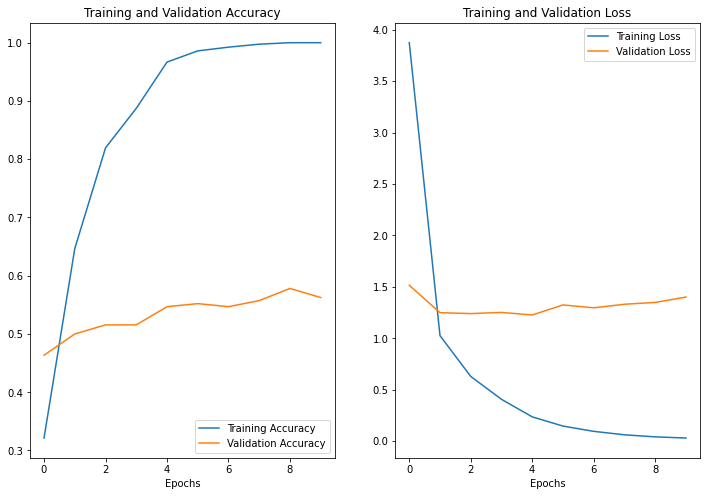

In [31]:
# Xception+Dense512 Balnced Data (973 images)

Epoch 1/10
113/113 [==============================] - 382s 3s/step - loss: 1.0721 - accuracy: 0.6823 - val_loss: 0.7484 - val_accuracy: 0.7392
Epoch 2/10
113/113 [==============================] - 377s 3s/step - loss: 0.6278 - accuracy: 0.7711 - val_loss: 0.7354 - val_accuracy: 0.7558
Epoch 3/10
113/113 [==============================] - 376s 3s/step - loss: 0.4630 - accuracy: 0.8325 - val_loss: 0.7588 - val_accuracy: 0.7659
Epoch 4/10
113/113 [==============================] - 377s 3s/step - loss: 0.3160 - accuracy: 0.8864 - val_loss: 0.8033 - val_accuracy: 0.7692
Epoch 5/10
113/113 [==============================] - 376s 3s/step - loss: 0.2171 - accuracy: 0.9246 - val_loss: 1.0298 - val_accuracy: 0.7586
Epoch 6/10
113/113 [==============================] - 384s 3s/step - loss: 0.1744 - accuracy: 0.9407 - val_loss: 0.9891 - val_accuracy: 0.7859
Epoch 7/10
113/113 [==============================] - 390s 3s/step - loss: 0.1149 - accuracy: 0.9603 - val_loss: 1.0779 - val_accuracy: 0.7853

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


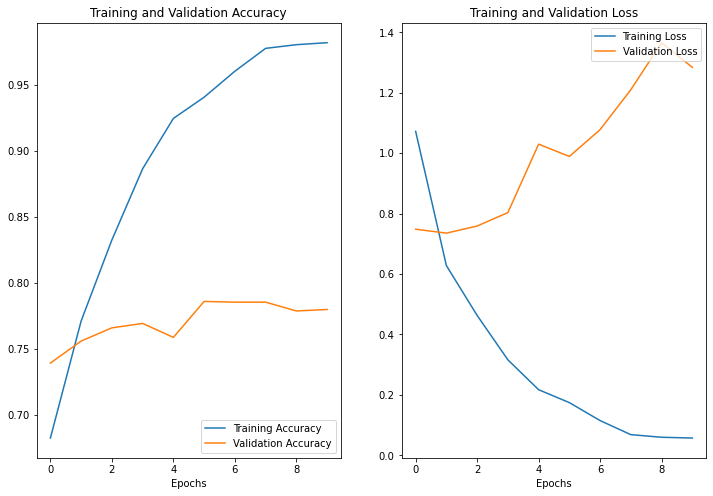

In [27]:
# Xception+Dense512 unfreeze Conv in Block 14

In [26]:
start_time = time.time()
evaluate_model(model, train_data, test_data)
print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

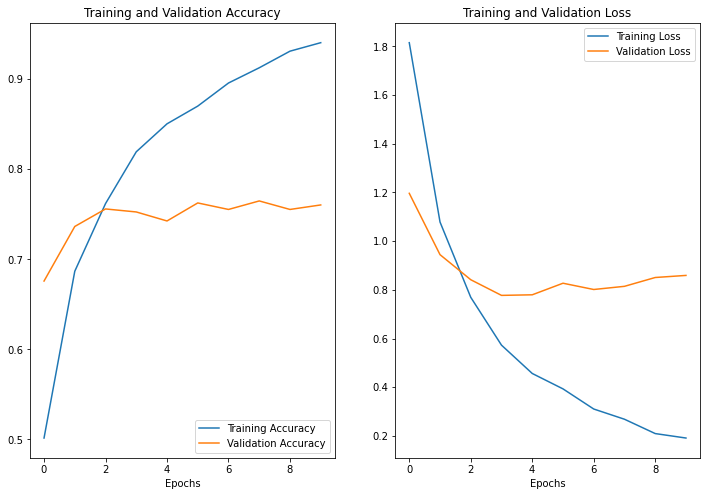

In [14]:
# Xception+Dense512+BN+DO
print_training_history(history)

In [ ]:
# VGG16    (BN+DO) 10 epochs 53/58 
# VGG16 _2 (BN+D0) 10 epochs 63/64

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file="output/vgg16.png")